# Embedding

In [58]:
import pandas as pd
import numpy as np
import string
import re
import operator
from tqdm.notebook import tqdm

In [59]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F900-\U0001FAFF"  # new emojis
                           "]+", flags=re.UNICODE)

def cleaning(data):
    
    ''' This functions clean the input text'''
    
    clean_data_hinglish = []
    
    for tweet in tqdm(data):
        clean_text = []
        tweet = re.sub(r'\\n', ' ', tweet)  # replacing '\\n' with a space
        tweet = re.sub(r',', ' ', tweet)    # replacing ','  with a space
        tweet = re.sub(r'RT|rt', '', tweet)
        
        for word in tweet.split():
            if word[0] == '@':              # removing user_ids 
                clean_word = re.sub(r'^@\w+', 'username', word)#word.replace(word, 'username')#re.sub(word, 'username', word)
            else:
                clean_word = word.lower()       # lowercase all the words
                clean_word = re.sub(r'^#\w+', ' ', clean_word) #remove hashtags
                #clean_word = re.sub(r'^\\[a-z0-9].*\\[a-z0-9{3}+]*[^\\n]$', '', clean_word)   # removing emotions in unicode
                clean_word = re.sub(r'\\', ' ', clean_word)
                clean_word = re.sub(r'^http\S+', '', clean_word)              # replacing url link with 'url'
                #clean_word = re.sub(r'^https:[\a-zA-Z0-9]+', '', clean_word)              # replacing url link with 'url'
                clean_word = emoji_pattern.sub(r'', clean_word)
                #clean_word = re.sub(r'[^a-z].\w+', '', clean_word)           # removing evering thing except a-z
                clean_word = re.sub(r'[!,.:_;$%^\'\#"&]', '', clean_word)
            clean_text.append(clean_word)
                
        clean_text = (' ').join(clean_text)
    
        clean_data_hinglish.append(clean_text)
        
    clean_data_hinglish = np.asarray(clean_data_hinglish)
    
        
    return clean_data_hinglish

In [60]:
df = pd.read_json('/kaggle/input/hinglish-tweets/hinglish_english_tweets.json')

In [61]:
df['tweet_text'] = cleaning(df['tweet_text'])

  0%|          | 0/366535 [00:00<?, ?it/s]

In [62]:
stop_words=[]
rare_words=[]
token_count = {}
nc=0
for line in df['tweet_text']:
    line = line.strip()
    line = re.split(r'\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*', line)
    line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
    if len(line) > 1:
        tokens = []
        for i in range(len(line)):
            #Counting Tokens
            if line[i].lower() in token_count:
                token_count[line[i].lower()] += 1
            else:
                token_count[line[i].lower()] = 1
        nc=nc+1

token_count = dict(sorted(token_count.items(), key=operator.itemgetter(1), reverse=True))
for key, value in token_count.items():
    if value >= 100:
        stop_words.append(key.lower())
    elif value <5:
        rare_words.append(key.lower())
print(nc)

364416


In [63]:
rare_words = set(rare_words)

In [64]:
id_tokenised_tweet_map = []
nc=0
for line in df['tweet_text']:
    line = line.strip()
    line = re.split(r'\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*', line)
    line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
    tokens = []
    if len(line) > 1:
        for i in range(len(line)):
            #Tokenizing Tweet    
            if line[i][0] == '#':
                tokens.append(line[i][1:])
            elif line[i][0] == '@' or line[i][0] in string.punctuation :
                continue
            elif 'http' in line[i]:
                tokens.append('URL')
            elif line[i].lower() in rare_words :
                continue
            else:
                tokens.append(line[i])
        nc=nc+1
    id_tokenised_tweet_map.append(tokens)

In [65]:
id_tokenised_tweet_map_removedEmpty = [x for x in id_tokenised_tweet_map if x != []]

In [66]:
data = id_tokenised_tweet_map_removedEmpty

## FastText Embedding

In [67]:
from gensim.models import FastText

model2 = FastText(data, vector_size=300, window=10, hs=0, negative = 1)

print("DONE!!!!")

# model2.save("hinglishFASTTEXT_rarewords_absent_scraped.model")
model2.save("hinglish_english_FASTTEXT_rarewords_absent_scraped.model")

print("Model saved!!!")

DONE!!!!
Model saved!!!


## Word2Vec Embedding

In [68]:
from gensim.models import Word2Vec

model4 = Word2Vec(data, vector_size=300, window=10, hs=0, negative = 1)

print("DONE!!!!")

# model4.save("hinglishWORD2VEC_rarewords_absent_scraped.model")
model4.save("hinglish_english_WORD2VEC_rarewords_absent_scraped.model")

print("Model saved!!!")

DONE!!!!
Model saved!!!


## IndicBERT Embedding

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import string
import re
import operator
import warnings
import os


warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
class PretrainingDataset(Dataset):
    def __init__(self, texts, tokenizer, texts_pair=None, max_length=512):
        super().__init__()
        
        self.texts = texts
        self.texts_pair = texts_pair
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        if self.texts_pair is not None:
            assert len(self.texts) == len(self.texts_pair)
        
    def __len__(self):
        return len(self.texts)
    
    def tokenize(self, text, text_pair=None):
        return self.tokenizer(
            text=text, 
            text_pair=text_pair,
            max_length=self.max_length,
            truncation=True,
            padding=False, 
            return_attention_mask=True,
            add_special_tokens=True,
            return_special_tokens_mask=True,
            return_token_type_ids=False,
            return_offsets_mapping=False,
            return_tensors=None,
        )
    
    def __getitem__(self, index):
        text = self.texts[index]
        
        text_pair = None
        if self.texts_pair is not None:
            text_pair = self.texts_pair[index]
            
        tokenized = self.tokenize(text)
        
        return tokenized

In [ ]:
texts = data['tweet_text'].values

In [ ]:
doc_len = np.array([len(words.split(" ")) for words in texts])
max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)

In [ ]:
model_name_or_path = "ai4bharat/indic-bert"
max_length = max_seq_len

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [ ]:
dataset = PretrainingDataset(
    texts=texts, 
    tokenizer=tokenizer, 
    max_length=max_length,
)

In [ ]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling


model = AutoModelForMaskedLM.from_pretrained(model_name_or_path)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=True, 
    mlm_probability=0.15,
)

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    save_steps=10000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

In [ ]:
trainer.train()

In [ ]:
# Save the fine-tuned IndicBert model
model.save_pretrained("indicBERT_embeddings_hinglish")
tokenizer.save_pretrained("indicbert_tokenizer")

# Model

## Embedding & DataLoader

In [1]:
!pip install fasttext

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import fasttext
from gensim.models import FastText, Word2Vec
from transformers import AutoModel, AutoTokenizer

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from tqdm.notebook import tqdm

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# from torch.nn.utils.rnn import pad_sequence

# # Desired max length
# max_len = 50

# # 100 seqs of variable length (< max_len)
# seq_lens = torch.randint(low=10,high=44,size=(100,))
# seqs = [torch.rand(n) for n in seq_lens]

# # pad first seq to desired length
# seqs[0] = nn.ConstantPad1d((0, max_len - seqs[0].shape[0]), 0)(seqs[0])

# # pad all seqs to desired length
# seqs = pad_sequence(seqs)

In [14]:
def init_embedding(embed_type="fasttext"):
    """
    Initializes fast text word embedding matrix
    """
    fasttext_embed_file = '/kaggle/working/hinglish_english_FASTTEXT_rarewords_absent_scraped.model'
    word2vec_embed_file = '/kaggle/working/hinglish_english_WORD2VEC_rarewords_absent_scraped.model'
    indicbert_embed_file = '/kaggle/input/hinglish-tweets/indicbert_models/indicBERT_embeddings_hinglish/'
    indicbert_tokenizer_file = '/kaggle/input/hinglish-tweets/indicbert_tokenizers/indic_tokenizer'

    if embed_type=="word2vec":
        embedding_index = Word2Vec.load(word2vec_embed_file)
        embedding_matrix = np.array([embedding_index.wv[word] for word, i in embedding_index.wv.key_to_index.items()])
        word2idx = embedding_index.wv.key_to_index
    elif embed_type=="fasttext":
        embedding_index = FastText.load(fasttext_embed_file)
        embedding_matrix = np.array([embedding_index.wv[word] for word, i in embedding_index.wv.key_to_index.items()])
        word2idx = embedding_index.wv.key_to_index
    elif embed_type=="indicbert":
        indic_embed = AutoModel.from_pretrained(indicbert_embed_file)
        tokenizer = AutoTokenizer.from_pretrained(indicbert_tokenizer_file)
        word2idx = tokenizer.get_vocab()
        indic_embedding = indic_embed.get_input_embeddings()
        embedding_matrix = np.array(indic_embedding.weight.data)  
    vocab_size , vocab_dim = embedding_matrix.shape
    return embedding_matrix, vocab_size, vocab_dim, word2idx

In [15]:
#initialize embedding matrix
embedding_matrix, vocab_size, vocab_dim, word2idx = init_embedding(embed_type="indicbert")

Some weights of the model checkpoint at /kaggle/input/hinglish-tweets/indicbert_models/indicBERT_embeddings_hinglish/ were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /kaggle/input/hinglish-tweets/indicbert_models/indicBERT_embeddings_hinglish/ and are newly initialized: ['

In [16]:
def tokenized_tensor(data, word2idx):
    """
    Returns tokenized tensor vector for input text=
    """
    output_tokenized = []

    for sentence in data:
        output = []
        tokenized = fasttext.tokenize(sentence)

        for word in tokenized:
            if word in word2idx:
                id = word2idx[word]
                output.append(id)
            else:
                word2idx[word] = len(word2idx)
                id = word2idx[word]
                output.append(id)

        output = torch.tensor(output)
        output_tokenized.append(output)

    return output_tokenized, word2idx

In [17]:
def get_data_sequences(train_dir, valid_dir, test_dir, word2idx):
    """
    Returns tokenized tensor sequences for the dataset
    """
    train_df = pd.read_csv(train_dir)
    val_df = pd.read_csv(valid_dir)
    test_df = pd.read_csv(test_dir)

    train_data =  train_df['tweets'].values
    train_labels = train_df['labels'].values

    val_data =  val_df['tweets'].values
    val_labels = val_df['labels'].values

    test_data =  test_df['tweets'].values
    test_labels = test_df['labels'].values

    train_tokenized_sequences, word2idx = tokenized_tensor(train_data, word2idx)
    test_tokenized_seqences, word2idx = tokenized_tensor(test_data, word2idx)
    val_tokenized_sequences, word2idx = tokenized_tensor(val_data, word2idx)

    return train_tokenized_sequences, train_labels, test_tokenized_seqences, test_labels, val_tokenized_sequences, val_labels, word2idx

In [18]:
# load sequences
train_file = '/kaggle/input/hinglish-tweets/train_labelled.csv'
valid_file = '/kaggle/input/hinglish-tweets/valid_labelled.csv'
test_file = '/kaggle/input/hinglish-tweets/test_labelled.csv'

train_sequences, train_labels, test_sequences, test_labels, val_sequences, val_labels, word2idx_updated = get_data_sequences(train_file, valid_file, test_file, word2idx)

In [19]:
def create_embedding(embedding_matrix, word2idx, vocab_size, vocab_dim):
    """
    Returns complete fasttext embedding matrix
    embedding_matrix = loaded embedded_matrix
    word2idx = updated vocab after loading train,valid,test dataset
    vocab_size = old vocab size
    vocab_dim = embedding dimension
    """
    word2idx['<PAD>'] = len(word2idx)

    random_init = torch.nn.Parameter(torch.Tensor( (len(word2idx) - vocab_size), vocab_dim))
    torch.nn.init.kaiming_uniform_(random_init, a=math.sqrt(5))

    new_matrix = np.zeros( (len(word2idx), vocab_dim) )
    new_matrix[:vocab_size, :] = embedding_matrix
    embedding_matrix = new_matrix
    embedding_matrix[vocab_size:, :] = random_init.detach().numpy()

    return embedding_matrix, word2idx

In [20]:
# get final embedding matrix
final_embedding_matrix, final_word2idx = create_embedding(embedding_matrix, word2idx_updated, vocab_size, vocab_dim)

In [21]:
class MyDataset(Dataset):
    """
    This is our custom dataset class which will load the text and their corresponding labels into Pytorch tensors
    """
    def __init__(self, sequences, labels, maxlen=29, pad_value=0):
        self.labels = labels
        self.sequences = sequences
        seq_len_list = np.array([len(words) for words in sequences])
        self.maxlen = np.round(seq_len_list.mean() + seq_len_list.std()).astype(int) 
        self.pad_value = pad_value
        for i, seq in enumerate(self.sequences):
            self.sequences[i] = self.pad_data(seq)

    def __getitem__(self, idx):
        sample = {}
        sequence = self.sequences[idx]
        label = torch.tensor(self.labels[idx])

        try:
            sample["label"] = label
            sample["token"] = sequence
        except Exception as e:
            print(e)
        
        return sample
    
    def __len__(self):
        return len(self.labels)

    def pad_data(self, s):
        padded = self.pad_value*torch.ones((self.maxlen,), dtype=torch.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [22]:
# # get dataset
# train_dataset = MyDataset(train_padded_sequences, train_labels)
# val_dataset = MyDataset(val_padded_sequences, val_labels)
# test_dataset = MyDataset(test_padded_sequences, test_labels)

# get dataset
train_dataset = MyDataset(train_sequences, train_labels, pad_value=final_word2idx['<PAD>'])
val_dataset = MyDataset(val_sequences, val_labels, pad_value=final_word2idx['<PAD>'])
test_dataset = MyDataset(test_sequences, test_labels, pad_value=final_word2idx['<PAD>'])

In [23]:
batch_size = 64

In [24]:
train_loader = DataLoader(
    train_dataset, 
    batch_size= batch_size, 
    shuffle=True,
    pin_memory=True, #load tensor to cuda if available
    num_workers=2,   #num of processes to load data
    drop_last=True   #drops last incomplete batch
)

val_loader = DataLoader(
    val_dataset, 
    batch_size= batch_size, 
    shuffle=True,
    pin_memory=True, #load tensor to cuda if available
    num_workers=2,   #num of processes to load data
    drop_last=True   #drops last incomplete batch
)

test_loader = DataLoader(
    test_dataset, 
    batch_size= batch_size, 
    shuffle=True,
    pin_memory=True, #load tensor to cuda if available
    num_workers=2,   #num of processes to load data
    drop_last=True   #drops last incomplete batch
)

dataloaders = {'Train': train_loader, 'Val': val_loader, 'Test': test_loader}

In [25]:
vocab_size = len(final_word2idx)
embed_dim = vocab_dim

## Helper Functions

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [27]:
def training_and_validation(model, epochs, lr=0.01, optimizer="adam"):

    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
        total_train = 0
        for data in tqdm(train_loader):
            inputs, labels = data['token'], data['label']
            inputs, labels = inputs.to(device), labels.to(device)

            model.zero_grad()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_losses.append(loss.item())
            accuracy = (torch.max(outputs.data, 1)[1] == labels).sum().item()
            train_acc += accuracy
            total_train += labels.size(0)
            optimizer.step()

        val_losses = []
        val_acc = 0.0    
        model.eval()
        total_test = 0
        y_pred, y_valid = [], []
        with torch.no_grad():
            for data in tqdm(val_loader):
                inputs, labels = data['token'], data['label']
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                y_pred += predicted
                y_valid += labels

                val_loss = criterion(outputs, labels)
                val_losses.append(val_loss.item())

                accuracy = (predicted == labels).sum().item()
                val_acc += accuracy
                total_test += labels.size(0)

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/total_train
        epoch_val_acc = val_acc/total_test
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        print(25*'==')

        if epoch == epochs-1:
            cm = confusion_matrix(torch.tensor(y_valid).cpu(), torch.tensor(y_pred).cpu())
            fig, ax = plot_confusion_matrix(conf_mat=cm)
            image_path = 'val_%s.png' % type(model).__name__
            plt.savefig(image_path)
            print(classification_report(torch.tensor(y_valid).cpu(), torch.tensor(y_pred).cpu()))

In [28]:
def infer(net, images):
    net.eval()
    outputs = net(images)
    return outputs

In [29]:
def evaluate(model):
    correct_outcomes = 0
    y_pred = []
    y_test = []
    for i, data in enumerate(test_loader):
        inputs, labels = data['token'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        output = infer(model, inputs)
        _, predicted = torch.max(output.data, 1)
        y_pred += predicted
        y_test += labels
        correct_outcomes += torch.sum(torch.argmax(output, dim=1) == labels)
        
    print("Test Accuracy: ", correct_outcomes/len(test_loader.dataset))
    cm = confusion_matrix(torch.tensor(y_test).cpu(), torch.tensor(y_pred).cpu())
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    image_path = 'test_%s.png' % type(model).__name__
    plt.savefig(image_path)
    print(classification_report(torch.tensor(y_test).cpu(), torch.tensor(y_pred).cpu()))

## Series CNN

In [30]:
class Series_CNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(Series_CNN, self).__init__()
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        
        self.features = nn.Sequential(
            nn.Conv1d(embedding_matrix.shape[1], 200, 7, padding='same'), #(embed_dim, num_kernels, kernel_size)
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(200, 200, 7, padding='same'), #(last output size, num_kernels, kernel_size)
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.globalpool = nn.Sequential(
            nn.AdaptiveMaxPool1d(1),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(200, 128),  #(num_kernels, next layer size)
            nn.ReLU(),
            nn.Linear(128, 64),  
            nn.ReLU(),
            # nn.Linear(64, 1),
            nn.Linear(64, 2),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        # print(f"After Embedding: {x}")
        x = x.permute(0, 2, 1)  # convert to (batch_size, embedding_dim, seq_len)
        # print(f"After permutation: {x}")
        x = self.features(x)
        # print(f"After Feature: {x}")
        x = self.globalpool(x)
        # print(f"After GlobalPool: {x}")
        x = x.view(x.size(0), -1)
        # print(f"After Flattening: {x}")
        x = self.classifier(x)
        # print(f"After Classifier: {x}")
        return x

In [31]:
series_model = Series_CNN(final_embedding_matrix)
series_model.to(device)
print(series_model)

Series_CNN(
  (embedding): Embedding(316565, 128)
  (features): Sequential(
    (0): Conv1d(128, 200, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=same)
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (globalpool): Sequential(
    (0): AdaptiveMaxPool1d(output_size=1)
    (1): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [32]:
dataiter = iter(train_loader)
data = next(dataiter)
inputs, labels = data['token'], data['label']
inputs, labels = inputs.to(device), labels.to(device)
outputs = series_model(inputs)
print(torch.max(outputs.data, 1)[1])
print(labels)
print((torch.max(outputs.data, 1)[1] == labels).sum().item())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
28


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.4312609984363253 val_loss : 0.2573057481230379
train_accuracy : 79.29838320463321 val_accuracy : 91.96227477477478


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.2468748025121491 val_loss : 0.233059332815108
train_accuracy : 92.34133687258688 val_accuracy : 92.75056306306307


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.22275871263536476 val_loss : 0.22345079793720632
train_accuracy : 92.91445463320464 val_accuracy : 92.96171171171171


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.19744228751085785 val_loss : 0.2110260323294111
train_accuracy : 93.62934362934364 val_accuracy : 93.02505630630631


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.17049357379898142 val_loss : 0.213193603262708
train_accuracy : 94.47544642857143 val_accuracy : 93.0954391891892


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.1430278204715879 val_loss : 0.22008276010888653
train_accuracy : 95.39997586872587 val_accuracy : 92.4901463963964


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.11510839739195916 val_loss : 0.22717180061112116
train_accuracy : 96.37578426640927 val_accuracy : 92.56756756756756


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.09380774931985755 val_loss : 0.2413106307991453
train_accuracy : 97.1042471042471 val_accuracy : 91.8285472972973


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.07732423932136946 val_loss : 0.2502338979225438
train_accuracy : 97.70149613899613 val_accuracy : 92.45495495495496


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.06567907377872544 val_loss : 0.26400992871673257
train_accuracy : 98.09664575289575 val_accuracy : 92.44791666666666
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7245
           1       0.91      0.93      0.92      6963

    accuracy                           0.92     14208
   macro avg       0.92      0.92      0.92     14208
weighted avg       0.92      0.92      0.92     14208



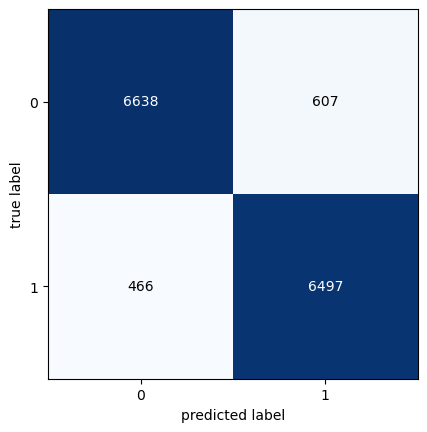

In [33]:
training_and_validation(series_model, 10, 0.0001)

Test Accuracy:  tensor(0.9255, device='cuda:0')
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7249
           1       0.92      0.93      0.93      6959

    accuracy                           0.93     14208
   macro avg       0.93      0.93      0.93     14208
weighted avg       0.93      0.93      0.93     14208



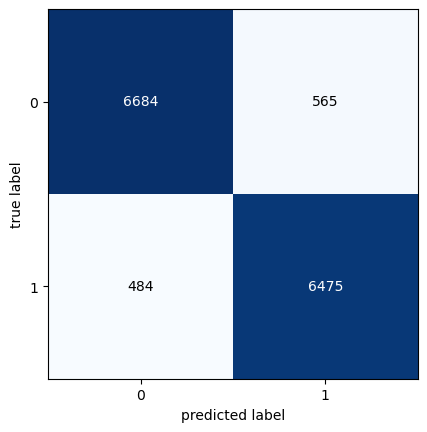

In [34]:
evaluate(series_model)

## Parallel CNN

In [35]:
class Parallel_CNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(Parallel_CNN, self).__init__()

        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.tower1 = nn.Sequential(
            nn.Conv1d(embedding_matrix.shape[1], 200, 3, padding='same'), #(embed_dim, num_kernels, kernel_size)
            nn.ReLU(),
        )
        self.tower2 = nn.Sequential(
            nn.Conv1d(embedding_matrix.shape[1], 200, 6, padding='same'), #(embed_dim, num_kernels, kernel_size)
            nn.ReLU(),
        )
        self.tower3 = nn.Sequential(
            nn.Conv1d(embedding_matrix.shape[1], 200, 9, padding='same'), #(embed_dim, num_kernels, kernel_size)
            nn.ReLU(),
        )
        self.tower4 = nn.Sequential(
            nn.Conv1d(embedding_matrix.shape[1], 200, 12, padding='same'), #(embed_dim, num_kernels, kernel_size)
            nn.ReLU(),
        )

        self.globalpool = nn.Sequential(
            nn.AdaptiveMaxPool1d(1),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(200, 128),  #(num_kernels, next layer size)
            nn.ReLU(),
            nn.Linear(128, 64),  
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.embedding(x)
        # print(f"After Embedding: {x.shape}")
        x = x.permute(0, 2, 1)  # convert to (batch_size, embedding_dim, seq_len)
        # print(f"After permutation: {x.shape}")
        x1 = self.tower1(x)
        x2 = self.tower2(x)
        x3 = self.tower3(x)
        x4 = self.tower4(x)
        x = torch.cat((x1, x2, x3, x4), -1)
        # print(f"After Concat: {x.shape}")
        x = self.globalpool(x)
        # print(f"After GlobalPool: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"After Flattening: {x.shape}")
        x = self.classifier(x)
        # print(f"After Classifier: {x.shape}")
        return x

In [36]:
model = Parallel_CNN(final_embedding_matrix)
model.to(device)
print(model)

Parallel_CNN(
  (embedding): Embedding(316565, 128)
  (tower1): Sequential(
    (0): Conv1d(128, 200, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (tower2): Sequential(
    (0): Conv1d(128, 200, kernel_size=(6,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (tower3): Sequential(
    (0): Conv1d(128, 200, kernel_size=(9,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (tower4): Sequential(
    (0): Conv1d(128, 200, kernel_size=(12,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (globalpool): Sequential(
    (0): AdaptiveMaxPool1d(output_size=1)
    (1): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [37]:
dataiter = iter(train_loader)
data = next(dataiter)
inputs, labels = data['token'], data['label']
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
print(torch.max(outputs.data, 1)[1])
print(labels)
print((torch.max(outputs.data, 1)[1] == labels).sum().item())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
36


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:895.)
  self.padding, self.dilation, self.groups)


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.5137077107968018 val_loss : 0.24796857939915615
train_accuracy : 72.88398889961391 val_accuracy : 92.61683558558559


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.2431917430681957 val_loss : 0.21056529312386169
train_accuracy : 92.14979488416989 val_accuracy : 93.06728603603604


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.2071033894735241 val_loss : 0.19350524914560016
train_accuracy : 93.09694739382239 val_accuracy : 93.46846846846847


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.18353742651972185 val_loss : 0.18495464387878374
train_accuracy : 93.76508204633205 val_accuracy : 93.6866554054054


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.16353330760834645 val_loss : 0.18073658749192684
train_accuracy : 94.53879102316603 val_accuracy : 93.77111486486487


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.14367267758402125 val_loss : 0.18066953646170125
train_accuracy : 95.18731901544402 val_accuracy : 93.91188063063063


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.12384175230716589 val_loss : 0.18718467604973027
train_accuracy : 95.95801158301158 val_accuracy : 93.8766891891892


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.11080807828053142 val_loss : 0.1838257563057112
train_accuracy : 96.43309604247105 val_accuracy : 93.82742117117117


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.09598061216376635 val_loss : 0.1927510161825397
train_accuracy : 96.941361003861 val_accuracy : 93.8766891891892


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.08488190182103528 val_loss : 0.19252025132143014
train_accuracy : 97.21434604247105 val_accuracy : 93.69369369369369
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7247
           1       0.93      0.94      0.94      6961

    accuracy                           0.94     14208
   macro avg       0.94      0.94      0.94     14208
weighted avg       0.94      0.94      0.94     14208



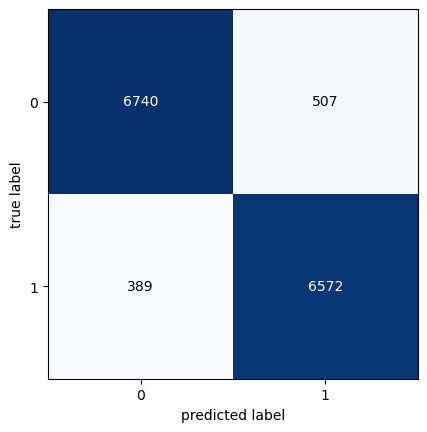

In [38]:
training_and_validation(model, 10, 0.0001)

Test Accuracy:  tensor(0.9375, device='cuda:0')
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7247
           1       0.93      0.94      0.94      6961

    accuracy                           0.94     14208
   macro avg       0.94      0.94      0.94     14208
weighted avg       0.94      0.94      0.94     14208



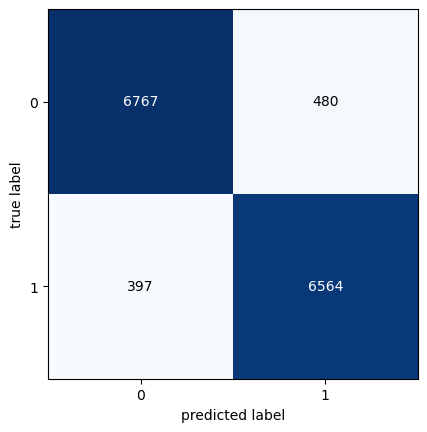

In [39]:
evaluate(model)

## LSTM

In [40]:
from torch.nn.modules import dropout
class LSTM_Model(nn.Module):
    def __init__(self, embedding_matrix, lstm_out=150):
        super(LSTM_Model, self).__init__()
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=lstm_out, dropout=0.2, batch_first=True)
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_out, 64),  #(lstm_out, next layer size)
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.classifier(x)
        return x

In [41]:
lstm_model = LSTM_Model(final_embedding_matrix)
lstm_model.to(device)
print(lstm_model)

LSTM_Model(
  (embedding): Embedding(316565, 128)
  (lstm): LSTM(128, 150, batch_first=True, dropout=0.2)
  (classifier): Sequential(
    (0): Linear(in_features=150, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [42]:
dataiter = iter(train_loader)
data = next(dataiter)
inputs, labels = data['token'], data['label']
inputs, labels = inputs.to(device), labels.to(device)
outputs = lstm_model(inputs)
print(torch.max(outputs.data, 1)[1])
print(labels)
print((torch.max(outputs.data, 1)[1] == labels).sum().item())

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
38


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6903921839813468 val_loss : 0.6929554147226317
train_accuracy : 52.00440395752896 val_accuracy : 51.027590090090094


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.6929679204598357 val_loss : 0.6928164746847238
train_accuracy : 51.2065637065637 val_accuracy : 52.58305180180181


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.6931681478805984 val_loss : 0.6929523708584072
train_accuracy : 50.63495415057915 val_accuracy : 51.00647522522522


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.693218155141963 val_loss : 0.6929811574854292
train_accuracy : 50.67416747104247 val_accuracy : 50.99943693693694


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.6932845889486401 val_loss : 0.6938620462073936
train_accuracy : 50.67416747104247 val_accuracy : 51.00647522522522


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.6933127254477799 val_loss : 0.6932122951692289
train_accuracy : 50.417772683397686 val_accuracy : 49.00056306306306


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.6932344253689166 val_loss : 0.6929531159164669
train_accuracy : 50.71941361003861 val_accuracy : 51.01351351351351


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.693385774967293 val_loss : 0.6939892414453868
train_accuracy : 50.606298262548265 val_accuracy : 49.00056306306306


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.6932886795762884 val_loss : 0.6930267606769596
train_accuracy : 50.384592181467184 val_accuracy : 50.99943693693694


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.6932766563528753 val_loss : 0.6930536853300558
train_accuracy : 50.66511824324324 val_accuracy : 51.027590090090094
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      7250
           1       0.00      0.00      0.00      6958

    accuracy                           0.51     14208
   macro avg       0.26      0.50      0.34     14208
weighted avg       0.26      0.51      0.34     14208



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


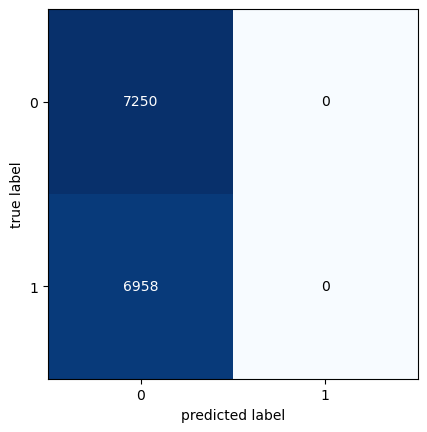

In [43]:
training_and_validation(lstm_model, 10, 0.007)

In [44]:
path = 'lstm-model.pt'
torch.save(lstm_model.state_dict(), path)

Test Accuracy:  tensor(0.5097, device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      7247
           1       0.00      0.00      0.00      6961

    accuracy                           0.51     14208
   macro avg       0.26      0.50      0.34     14208
weighted avg       0.26      0.51      0.34     14208



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


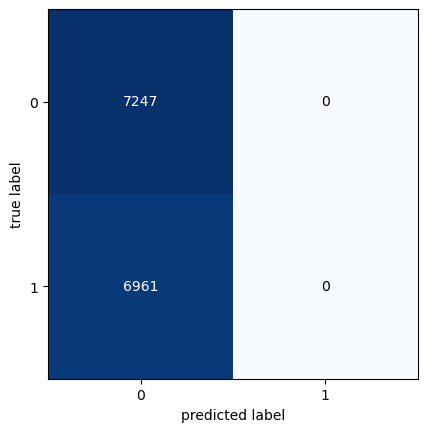

In [45]:
evaluate(lstm_model)

## Bi-LSTM

In [46]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [47]:
from torch.nn.modules import dropout
class BiLSTM_Model(nn.Module):
    def __init__(self, embedding_matrix, lstm_out=150, max_seq_len=27):
        super(BiLSTM_Model, self).__init__()
        
        self.max_seq_len = max_seq_len
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        
        self.bilstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=lstm_out, bidirectional=True, dropout=0.2, batch_first=True)
        
        self.timedistributed = TimeDistributed(
            nn.Linear(lstm_out + lstm_out, 10),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(self.max_seq_len * 10, 64),  #(input, next layer size)
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        self.max_seq_len = x.size(1)
        x = self.embedding(x)
#         print(f"After Embedding: {x.shape}")
        x, _ = self.bilstm(x)
#         print(f"After BiLSTM: {x.shape}")
        x = self.timedistributed(x)
#         print(f"After TimeDistributed: {x.shape}")
        x = x.view(x.size(0), -1)
#         print(f"After Flattening: {x.shape}")
        x = self.classifier(x)
#         print(f"After Classifier: {x.shape}")
        return x

In [48]:
bilstm_model = BiLSTM_Model(final_embedding_matrix)
bilstm_model.to(device)
print(bilstm_model)

BiLSTM_Model(
  (embedding): Embedding(316565, 128)
  (bilstm): LSTM(128, 150, batch_first=True, dropout=0.2, bidirectional=True)
  (timedistributed): TimeDistributed(
    (module): Linear(in_features=300, out_features=10, bias=True)
    (batch_first): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=270, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [49]:
dataiter = iter(train_loader)
data = next(dataiter)
inputs, labels = data['token'], data['label']
inputs, labels = inputs.to(device), labels.to(device)
outputs = bilstm_model(inputs)
print(torch.max(outputs.data, 1)[1])
print(labels)
print((torch.max(outputs.data, 1)[1] == labels).sum().item())

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
30


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.3861569603149955 val_loss : 0.2512652894968654
train_accuracy : 83.15637065637065 val_accuracy : 92.64498873873875


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.2494050350766557 val_loss : 0.24593288511843295
train_accuracy : 92.48461631274131 val_accuracy : 92.81390765765765


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.24164603497027545 val_loss : 0.22851533622287953
train_accuracy : 92.4484194015444 val_accuracy : 92.65202702702703


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.22891331127661363 val_loss : 0.21937387614502563
train_accuracy : 92.53287886100387 val_accuracy : 92.65202702702703


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.21965682267437917 val_loss : 0.21627796753435521
train_accuracy : 92.71687982625483 val_accuracy : 92.63091216216216


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.2133889935522351 val_loss : 0.21118467529346277
train_accuracy : 92.88127413127413 val_accuracy : 92.96171171171171


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.20642361227552403 val_loss : 0.20565295294934027
train_accuracy : 92.88881515444015 val_accuracy : 92.97578828828829


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.2001679020297343 val_loss : 0.19913634446424408
train_accuracy : 92.98835666023166 val_accuracy : 92.95467342342343


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.19509362183065374 val_loss : 0.20159292655686536
train_accuracy : 93.1648166023166 val_accuracy : 92.91244369369369


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.19063060133786275 val_loss : 0.20300401562640258
train_accuracy : 93.2598334942085 val_accuracy : 92.92652027027027
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7246
           1       0.91      0.95      0.93      6962

    accuracy                           0.93     14208
   macro avg       0.93      0.93      0.93     14208
weighted avg       0.93      0.93      0.93     14208



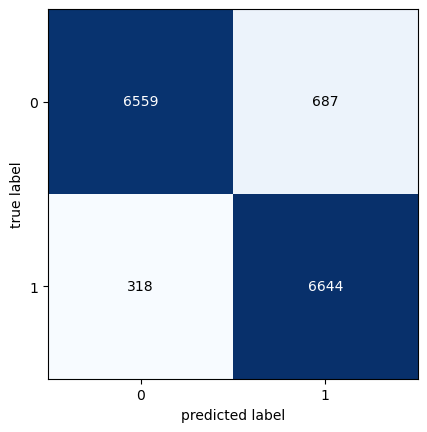

In [50]:
training_and_validation(bilstm_model, 10, 0.001)

In [51]:
path = 'bilstm-model.pt'
torch.save(bilstm_model.state_dict(), path)

Test Accuracy:  tensor(0.9325, device='cuda:0')
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7247
           1       0.91      0.96      0.93      6961

    accuracy                           0.93     14208
   macro avg       0.93      0.93      0.93     14208
weighted avg       0.93      0.93      0.93     14208



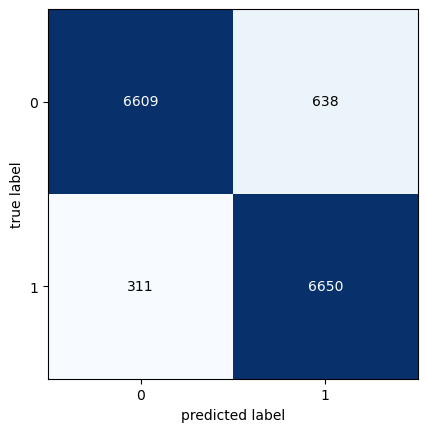

In [52]:
evaluate(bilstm_model)

## Attention BiLSTM

In [53]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
#         print(f"After Reshaping : {x_reshape.shape}")
        a = self.linear(x_reshape)
#         print(f"After Linear : {a.shape}")
        # We have to reshape Y
        a = a.contiguous().view(x.size(0), -1, a.size(-1))  # (samples, timesteps, output_size)
#         print(f"After Reshaping : {a.shape}")
        a = self.tanh(a)
#         print(f"After TanH : {a.shape}")
        a = self.softmax(a)
#         print(f"After Softmax : {a.shape}")
#         x = torch.matmul(a, x)
        x = a*x
#         print(f"After WeightedSum : {x.shape}")
        x = torch.sum(x, dim=1)
#         print(f"After WeightedSum Addition: {x.shape}")
        return x

In [54]:
# class Attention(nn.Module):
#     def __init__(self, hidden_dim):
#         super(Attention, self).__init__()
#         self.linear = nn.Linear(hidden_dim, 1)
#         self.tanh = nn.Tanh()
#         self.softmax = nn.Softmax()
        
#     def forward(self, x):
#         seq_len = x.size(1)
#         embed_dim = x.size(-1)
#         a = x.view(-1, embed_dim)
#         print(f"After Reshaping : {a.shape}")
#         a = self.linear(x)
#         a = a.view(-1, seq_len)
#         print(f"Before Tanh : {a.shape}")
#         a = self.tanh(a)
#         a = self.softmax(a)
#         print(f"After Attention Weights : {a.shape}")
#         a = a.unsqueeze(-1)
#         x = torch.matmul(a, x)
#         x = torch.sum(x, dim=1)
#         print(f"Final Dim : {x.shape}")
#         return x

In [55]:
from torch.nn.modules import dropout
class Attention_BiLSTM_Model(nn.Module):
    def __init__(self, embedding_matrix, lstm_out=150, max_seq_len=27):
        super(Attention_BiLSTM_Model, self).__init__()
        
        self.max_seq_len = max_seq_len
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        
        self.bilstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=lstm_out, bidirectional=True, dropout=0.2, batch_first=True)
        
        self.attention = Attention(2*lstm_out)
        
        self.classifier = nn.Sequential(
            nn.Linear(2*lstm_out, 64),  #(input, next layer size)
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        self.max_seq_len = x.size(1)
        x = self.embedding(x)
#         print(f"After Embedding: {x.shape}")
        x, _ = self.bilstm(x)
#         print(f"After BiLSTM: {x.shape}")
        x = self.attention(x)
#         print(f"After Attention: {x.shape}")
        x = self.classifier(x)
#         print(f"After Classifier: {x.shape}")
        return x

In [56]:
attention_bilstm_model = Attention_BiLSTM_Model(final_embedding_matrix)
attention_bilstm_model.to(device)
print(attention_bilstm_model)

Attention_BiLSTM_Model(
  (embedding): Embedding(316565, 128)
  (bilstm): LSTM(128, 150, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): Attention(
    (linear): Linear(in_features=300, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [57]:
dataiter = iter(train_loader)
data = next(dataiter)
inputs, labels = data['token'], data['label']
inputs, labels = inputs.to(device), labels.to(device)
outputs = attention_bilstm_model(inputs)
print(torch.max(outputs.data, 1)[1])
print(labels)
print((torch.max(outputs.data, 1)[1] == labels).sum().item())

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
35


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.39010697742744305 val_loss : 0.2608430771543099
train_accuracy : 83.20915781853282 val_accuracy : 92.44087837837837


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.25696346213731874 val_loss : 0.2668332971699603
train_accuracy : 92.29005791505791 val_accuracy : 92.20861486486487


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.24861235538332158 val_loss : 0.24472693350535255
train_accuracy : 92.45445222007721 val_accuracy : 92.65202702702703


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.24324368125252052 val_loss : 0.2345508787747439
train_accuracy : 92.50573117760618 val_accuracy : 92.57460585585585


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.23534734414092132 val_loss : 0.2205722232659658
train_accuracy : 92.55550193050193 val_accuracy : 92.75056306306307


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.22053310168640955 val_loss : 0.21176109513318217
train_accuracy : 92.70330598455598 val_accuracy : 92.8420608108108


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.20908661581877921 val_loss : 0.20013370015868195
train_accuracy : 92.8390444015444 val_accuracy : 93.02505630630631


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.20227977604709538 val_loss : 0.19671499086460015
train_accuracy : 92.98081563706563 val_accuracy : 93.12359234234235


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.19913470330126729 val_loss : 0.19536050335244015
train_accuracy : 93.03058638996139 val_accuracy : 93.10951576576578


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.1963568721541912 val_loss : 0.19427457139701457
train_accuracy : 93.0954391891892 val_accuracy : 92.91244369369369
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7247
           1       0.91      0.95      0.93      6961

    accuracy                           0.93     14208
   macro avg       0.93      0.93      0.93     14208
weighted avg       0.93      0.93      0.93     14208



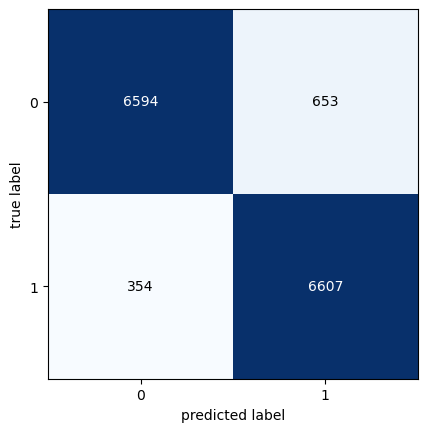

In [58]:
training_and_validation(attention_bilstm_model, 10, 0.001)

Test Accuracy:  tensor(0.9316, device='cuda:0')
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7245
           1       0.91      0.95      0.93      6963

    accuracy                           0.93     14208
   macro avg       0.93      0.93      0.93     14208
weighted avg       0.93      0.93      0.93     14208



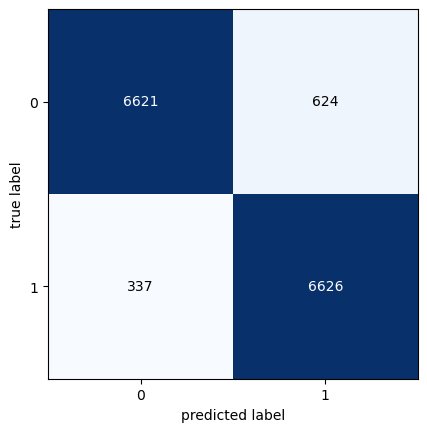

In [59]:
evaluate(attention_bilstm_model)